# Hotel Booking Demand Analysis

# 0) Environment Setup

Import all necessary libraries for data processing, visualization, and machine learning.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# 1) Preprocessing

Data preprocessing pipeline including loading, cleaning, validation, and feature engineering.

## 1.0) Load Dataset

In [2]:
# Load raw dataset
csv_path = "../../data/hotel_bookings.csv"
df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 1.1) BEFORE CLEANING - Missing Values Overview

Missing values PER COLUMN (before cleaning):
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent       

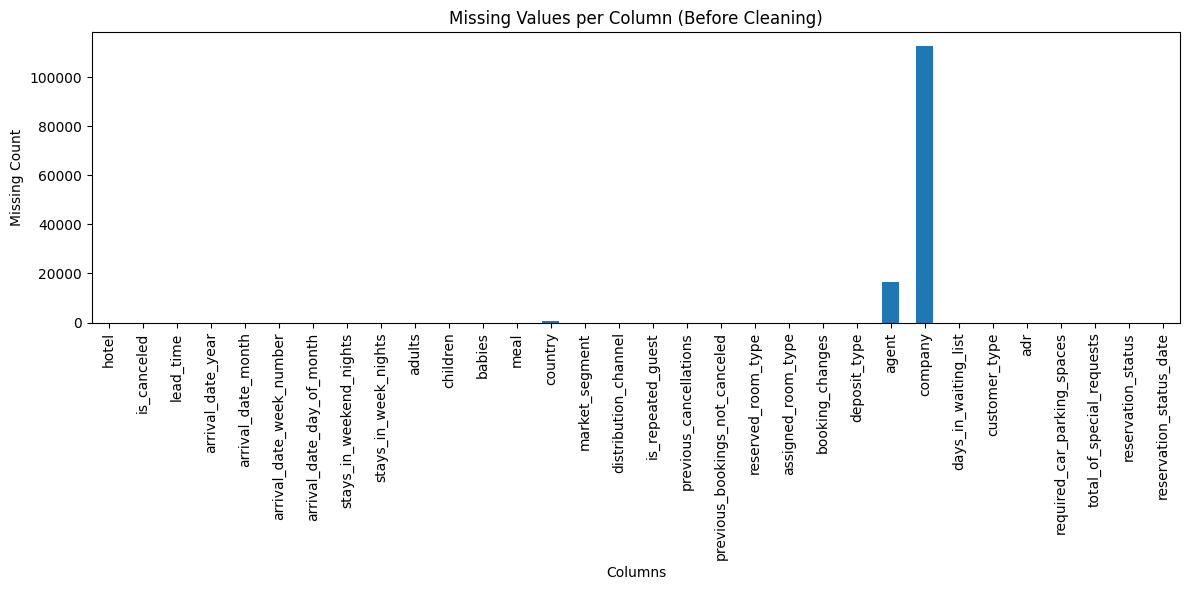

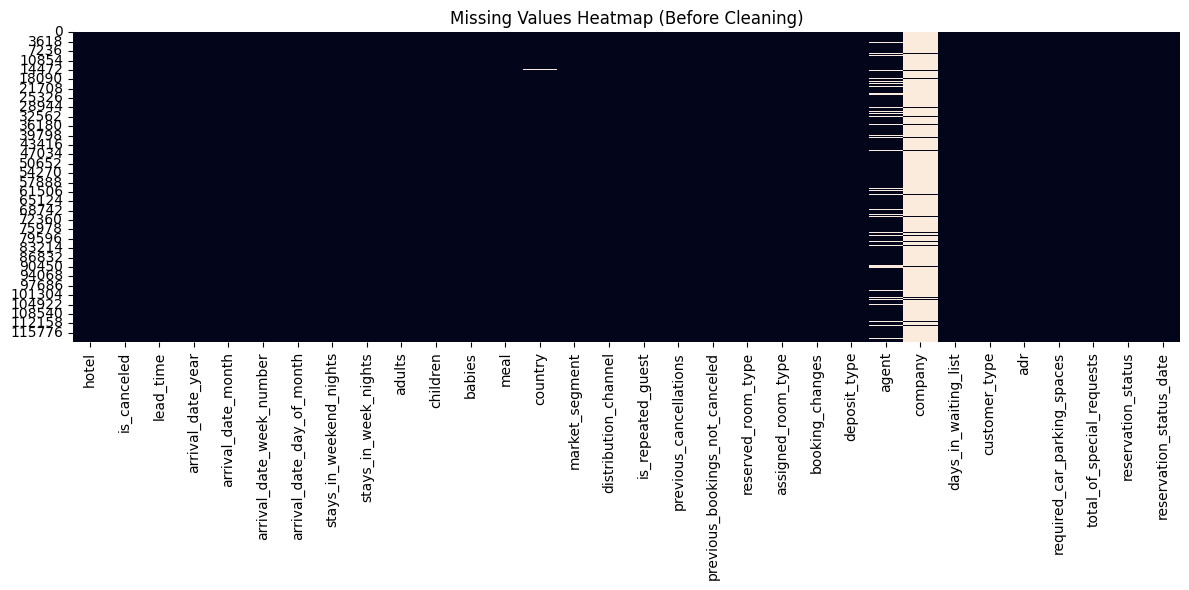

In [3]:
print("Missing values PER COLUMN (before cleaning):")
print(df.isna().sum())

print("\nTotal missing before cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (Before Cleaning)")
plt.tight_layout()
plt.show()

## 1.2) Handle Missing Values

In [4]:
df["children"] = df["children"].fillna(0)
df["country"] = df["country"].fillna("Unknown")
df["agent"] = df["agent"].fillna(0)
df["company"] = df["company"].fillna(0)

print("\nMissing values handled.")


Missing values handled.


## 1.3) AFTER CLEANING - Missing Values Check


Missing values PER COLUMN (after cleaning):
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type      

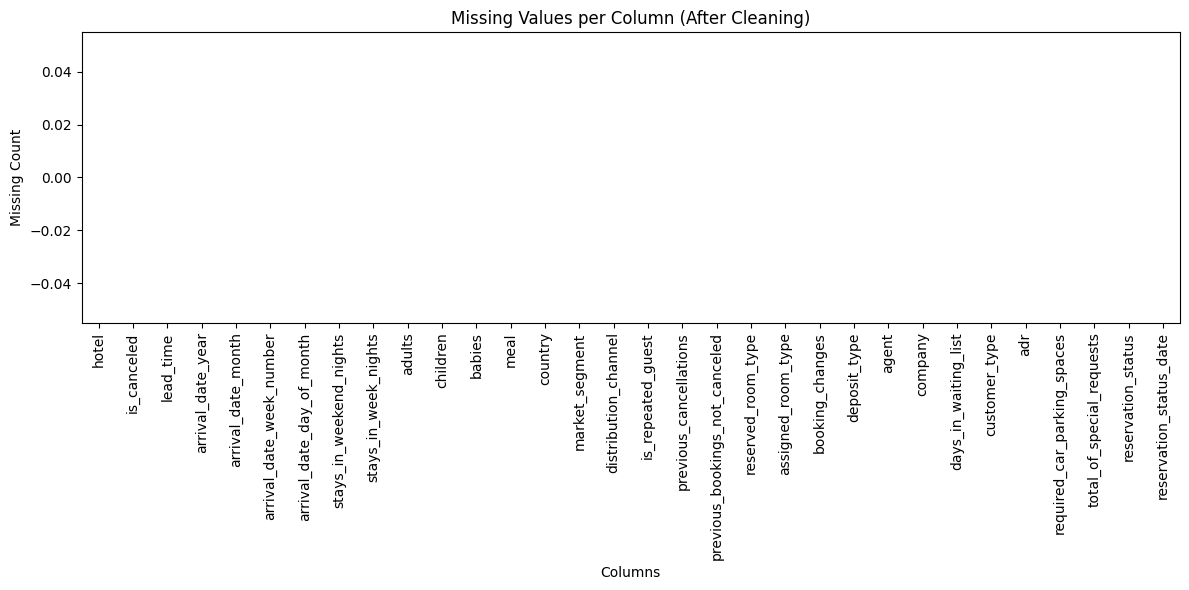

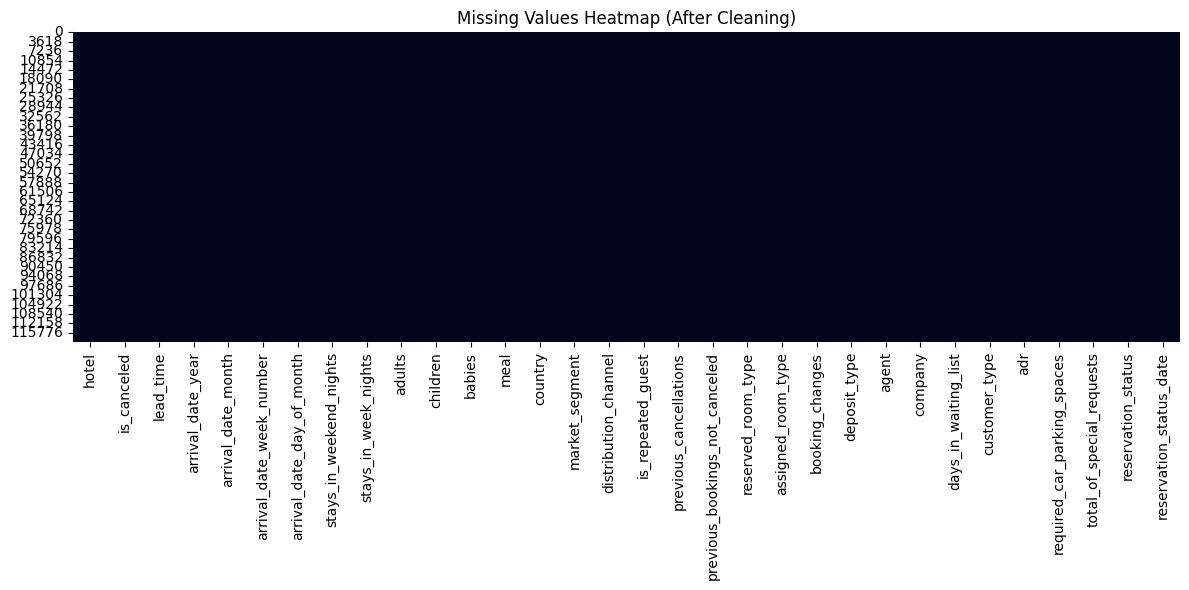

In [5]:
print("\nMissing values PER COLUMN (after cleaning):")
print(df.isna().sum())

print("\nTotal missing after cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (After Cleaning)")
plt.tight_layout()
plt.show()

## 1.4) Remove Invalid Rows (Bookings with no guests)

In [6]:
invalid_rows = (df["adults"] == 0) & (df["children"] == 0) & (df["babies"] == 0)
print("Number of invalid rows with no guests:", invalid_rows.sum())

df = df[~invalid_rows]
print("Shape after removing invalid rows:", df.shape)

Number of invalid rows with no guests: 180
Shape after removing invalid rows: (119210, 32)


## 1.5) Create Derived Variables

In [7]:
df["total_guests"] = df["adults"] + df["children"] + df["babies"]
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    errors="coerce"
)

df = df.dropna(subset=["arrival_date"])

df["arrival_month"] = df["arrival_date"].dt.month
df["arrival_weekday"] = df["arrival_date"].dt.day_name()

print("\nDerived variables created.")
print(df[["total_guests", "total_nights", "arrival_date"]].head())


Derived variables created.
   total_guests  total_nights arrival_date
0           2.0             0   2015-07-01
1           2.0             0   2015-07-01
2           1.0             1   2015-07-01
3           1.0             1   2015-07-01
4           2.0             2   2015-07-01


## 1.6) Data Validation

In [8]:
class DataValidationError(Exception):
    """Custom exception for data validation errors."""
    pass


if df.empty:
    raise DataValidationError("Dataset became empty after cleaning.")

if not df["is_canceled"].isin([0, 1]).all():
    raise DataValidationError("Invalid values found in is_canceled column.")

if (df["total_guests"] <= 0).any():
    raise DataValidationError("Found rows with zero or negative guests.")

if (df["total_nights"] < 0).any():
    raise DataValidationError("Found negative night counts.")

if not pd.api.types.is_datetime64_any_dtype(df["arrival_date"]):
    raise DataValidationError("arrival_date is not datetime type.")

print("\nValidation passed successfully.")


Validation passed successfully.


## 1.7) Save Cleaned Dataset

In [9]:
OUTPUT_PATH = "../../data/hotel_bookings_clean.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Cleaned dataset saved to {OUTPUT_PATH}")

Cleaned dataset saved to ../../data/hotel_bookings_clean.csv


# 2) Exploratory Data Analysis

Comprehensive analysis of hotel booking patterns, cancellations, and feature relationships.

## 2.0) Load Cleaned Data

In [10]:
# Load cleaned dataset for EDA
DATA_PATH = os.path.join("../..", "data", "hotel_bookings_clean.csv")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)

Dataset loaded. Shape: (119210, 37)


## 2.1) Descriptive Statistics for Key Variables

In [11]:
print("Average ADR:", df['adr'].mean())
print("Total bookings:", len(df))
print("Range of lead_time:", df['lead_time'].max() - df['lead_time'].min())

Average ADR: 101.96909177082459
Total bookings: 119210
Range of lead_time: 737


In [12]:
key_vars = ["lead_time", "adr", "total_guests", "total_nights"]
df[key_vars].describe()

,lead_time,adr,total_guests,total_nights
count,119210.000000,119210.000000,119210.000000,119210.000000
mean,104.109227,101.969092,1.971210,3.426248
std,106.875450,50.434007,0.718876,2.540692
min,0.000000,-6.380000,1.000000,0.000000
25%,18.000000,69.500000,2.000000,2.000000
50%,69.000000,94.950000,2.000000,3.000000
75%,161.000000,126.000000,2.000000,4.000000
max,737.000000,5400.000000,55.000000,69.000000


## 2.2) Cancelled vs. Non-Cancelled Bookings

In [13]:
df["is_canceled"].value_counts(normalize=True) * 100

is_canceled
0    62.923412
1    37.076588
Name: proportion, dtype: float64

Comparing cancelled vs. non-cancelled bookings. 62.9% of bookings were not cancelled, whereas 37.1% were cancelled.

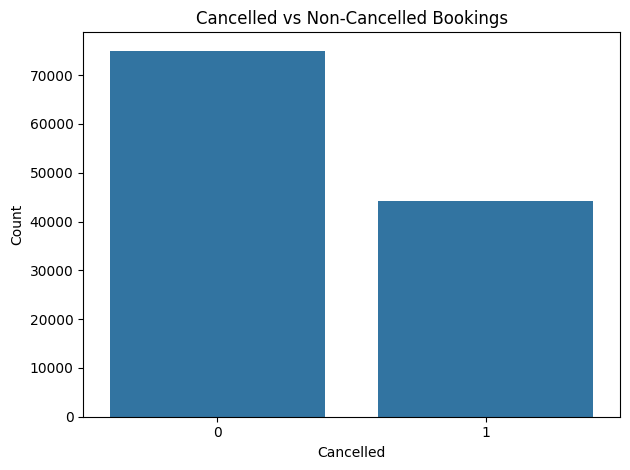

In [14]:
sns.countplot(x="is_canceled", data=df)
plt.xlabel("Cancelled")
plt.ylabel("Count")
plt.title("Cancelled vs Non-Cancelled Bookings")
plt.tight_layout()
plt.show()

Displaying a count of cancelled vs. non-cancelled bookings ~75,000 bookings were not cancelled and ~45,000 were.

In [15]:
grouped_means = df.groupby("is_canceled")[key_vars].mean()
print(grouped_means)

              lead_time         adr  total_guests  total_nights
is_canceled                                                    
0             80.082028  100.169212      1.946475      3.390063
1            144.886264  105.023703      2.013190      3.487658


Canceled bookings tend to be made much further in advance than non-canceled bookings, with an average lead time of about 145 days compared to 80 days. Canceled reservations also have slightly higher average daily rates, marginally more guests, and slightly longer stays. This suggests that bookings made far ahead of time are more uncertain and therefore more likely to be canceled, while differences in price and group size play a smaller role.

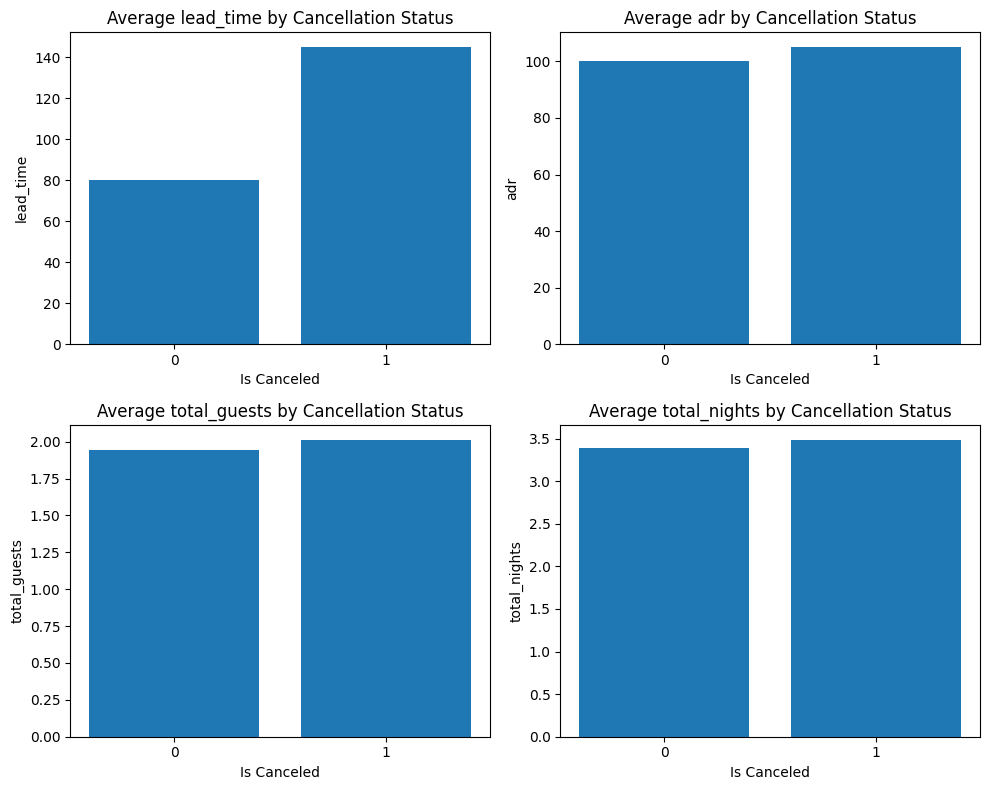

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, var in enumerate(key_vars):
    axes[i].bar(grouped_means.index.astype(str), grouped_means[var])
    axes[i].set_title(f"Average {var} by Cancellation Status")
    axes[i].set_xlabel("Is Canceled")
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

This is a visualization of the above findings.

## 2.3) Cancellations by Deposit Type

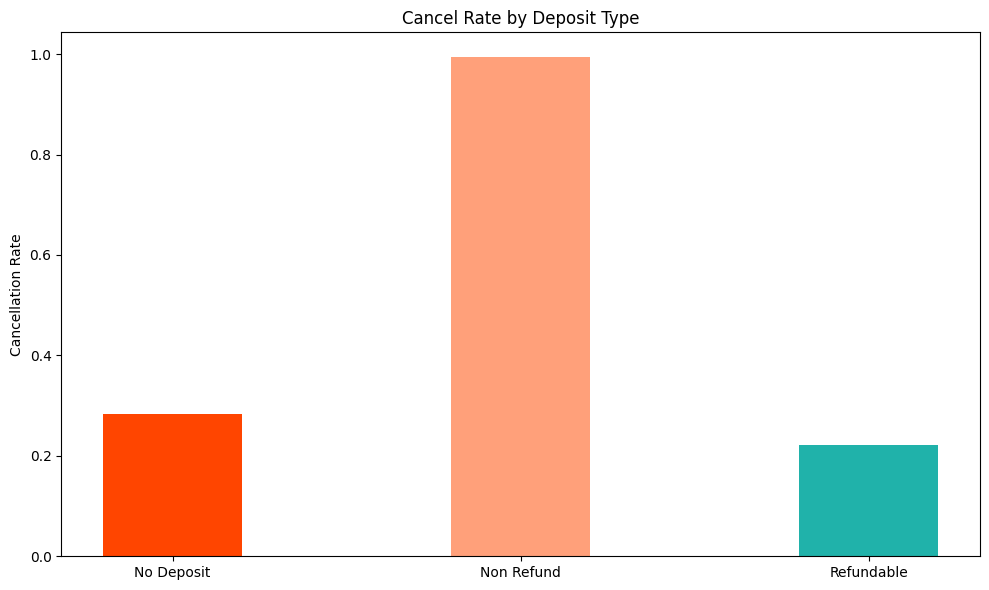

In [17]:
deposit_cancel=(df[df['is_canceled']==1]['deposit_type'].value_counts()/df['deposit_type'].value_counts())
x=range(len(deposit_cancel.index))
y=deposit_cancel.values
plt.figure(figsize=(10, 6))
plt.bar(x,y,color=['orangered','lightsalmon','lightseagreen'],width=0.4)
plt.xticks(x,deposit_cancel.index)
plt.title('Cancel Rate by Deposit Type')
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

Bookings with refundable or no-deposit policies have significantly higher cancellation rates, while non-refundable bookings are much less likely to be canceled. This suggests that stricter deposit policies discourage cancellations.

## 2.4) Seasonal Cancellation Patterns

In [18]:
book_per_month = df.groupby("arrival_date_month").size()
cancel_per_month = df.groupby("arrival_date_month")["is_canceled"].sum()

# Create Dataframe
full_cancel_data = pd.DataFrame({
    "Month": list(book_per_month.index),
    "Bookings": list(book_per_month.values),
    "cancellations": list(cancel_per_month.values)})

full_cancel_data["cancel_percent"] = full_cancel_data["cancellations"] / full_cancel_data["Bookings"] * 100

# Order by month
ordered_months = ["January", "February", "March", "April", "May", "June",
                  "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# Display the table sorted by month
display(full_cancel_data.sort_values("Month"))

,Month,Bookings,cancellations,cancel_percent
4,January,5921,1806,30.501604
3,February,8052,2693,33.445107
7,March,9768,3148,32.227682
0,April,11078,4518,40.783535
8,May,11780,4677,39.702886
6,June,10929,4534,41.485955
5,July,12644,4737,37.464410
1,August,13861,5237,37.782267
11,September,10500,4115,39.190476
10,October,11147,4246,38.090966


Cancellation rates show clear seasonality across the year. They are lowest in the winter months (January–March), averaging around 30–33%, and rise during the spring and summer period. The highest cancellation rates occur between April and June, peaking in June at over 41%, before gradually declining toward the end of the year. This suggests that bookings made for peak travel seasons are more uncertain and therefore more likely to be canceled.

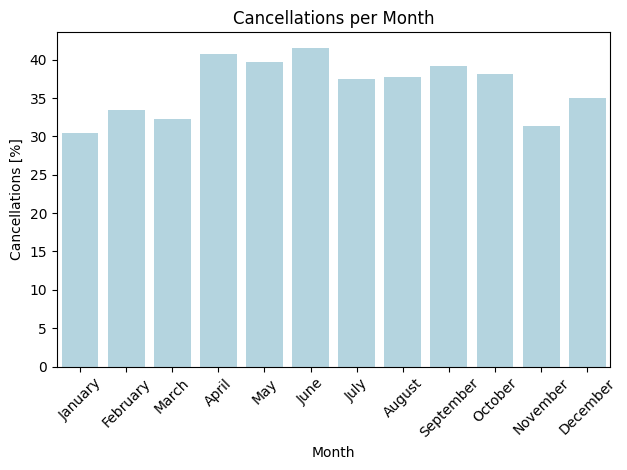

In [19]:
sns.barplot(x="Month", y="cancel_percent", data=full_cancel_data, color='lightblue')
plt.title("Cancellations per Month")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Cancellations [%]")
plt.tight_layout()
plt.show()

## 2.5) Distribution Analysis

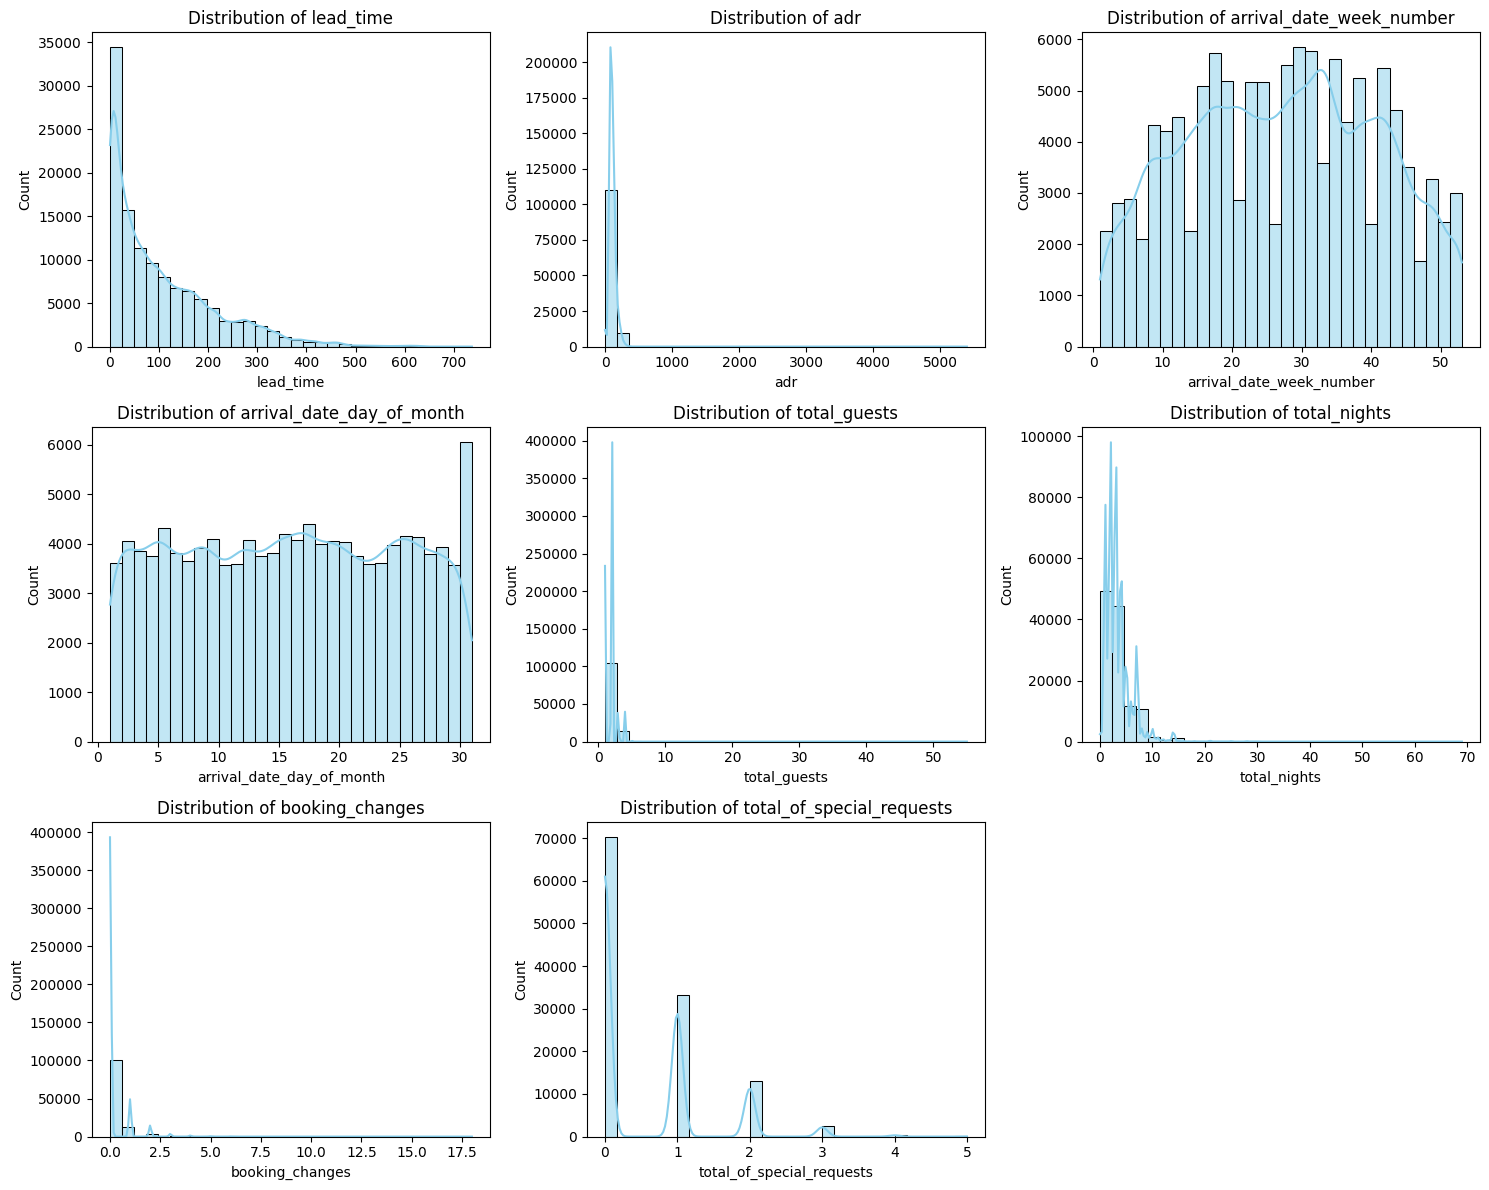

In [20]:
numeric_features = ["lead_time", "adr","arrival_date_week_number", "arrival_date_day_of_month", "total_guests", "total_nights","booking_changes", "total_of_special_requests"]

# Subplot layout
n_num = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n_num / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Distribution of {col}")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

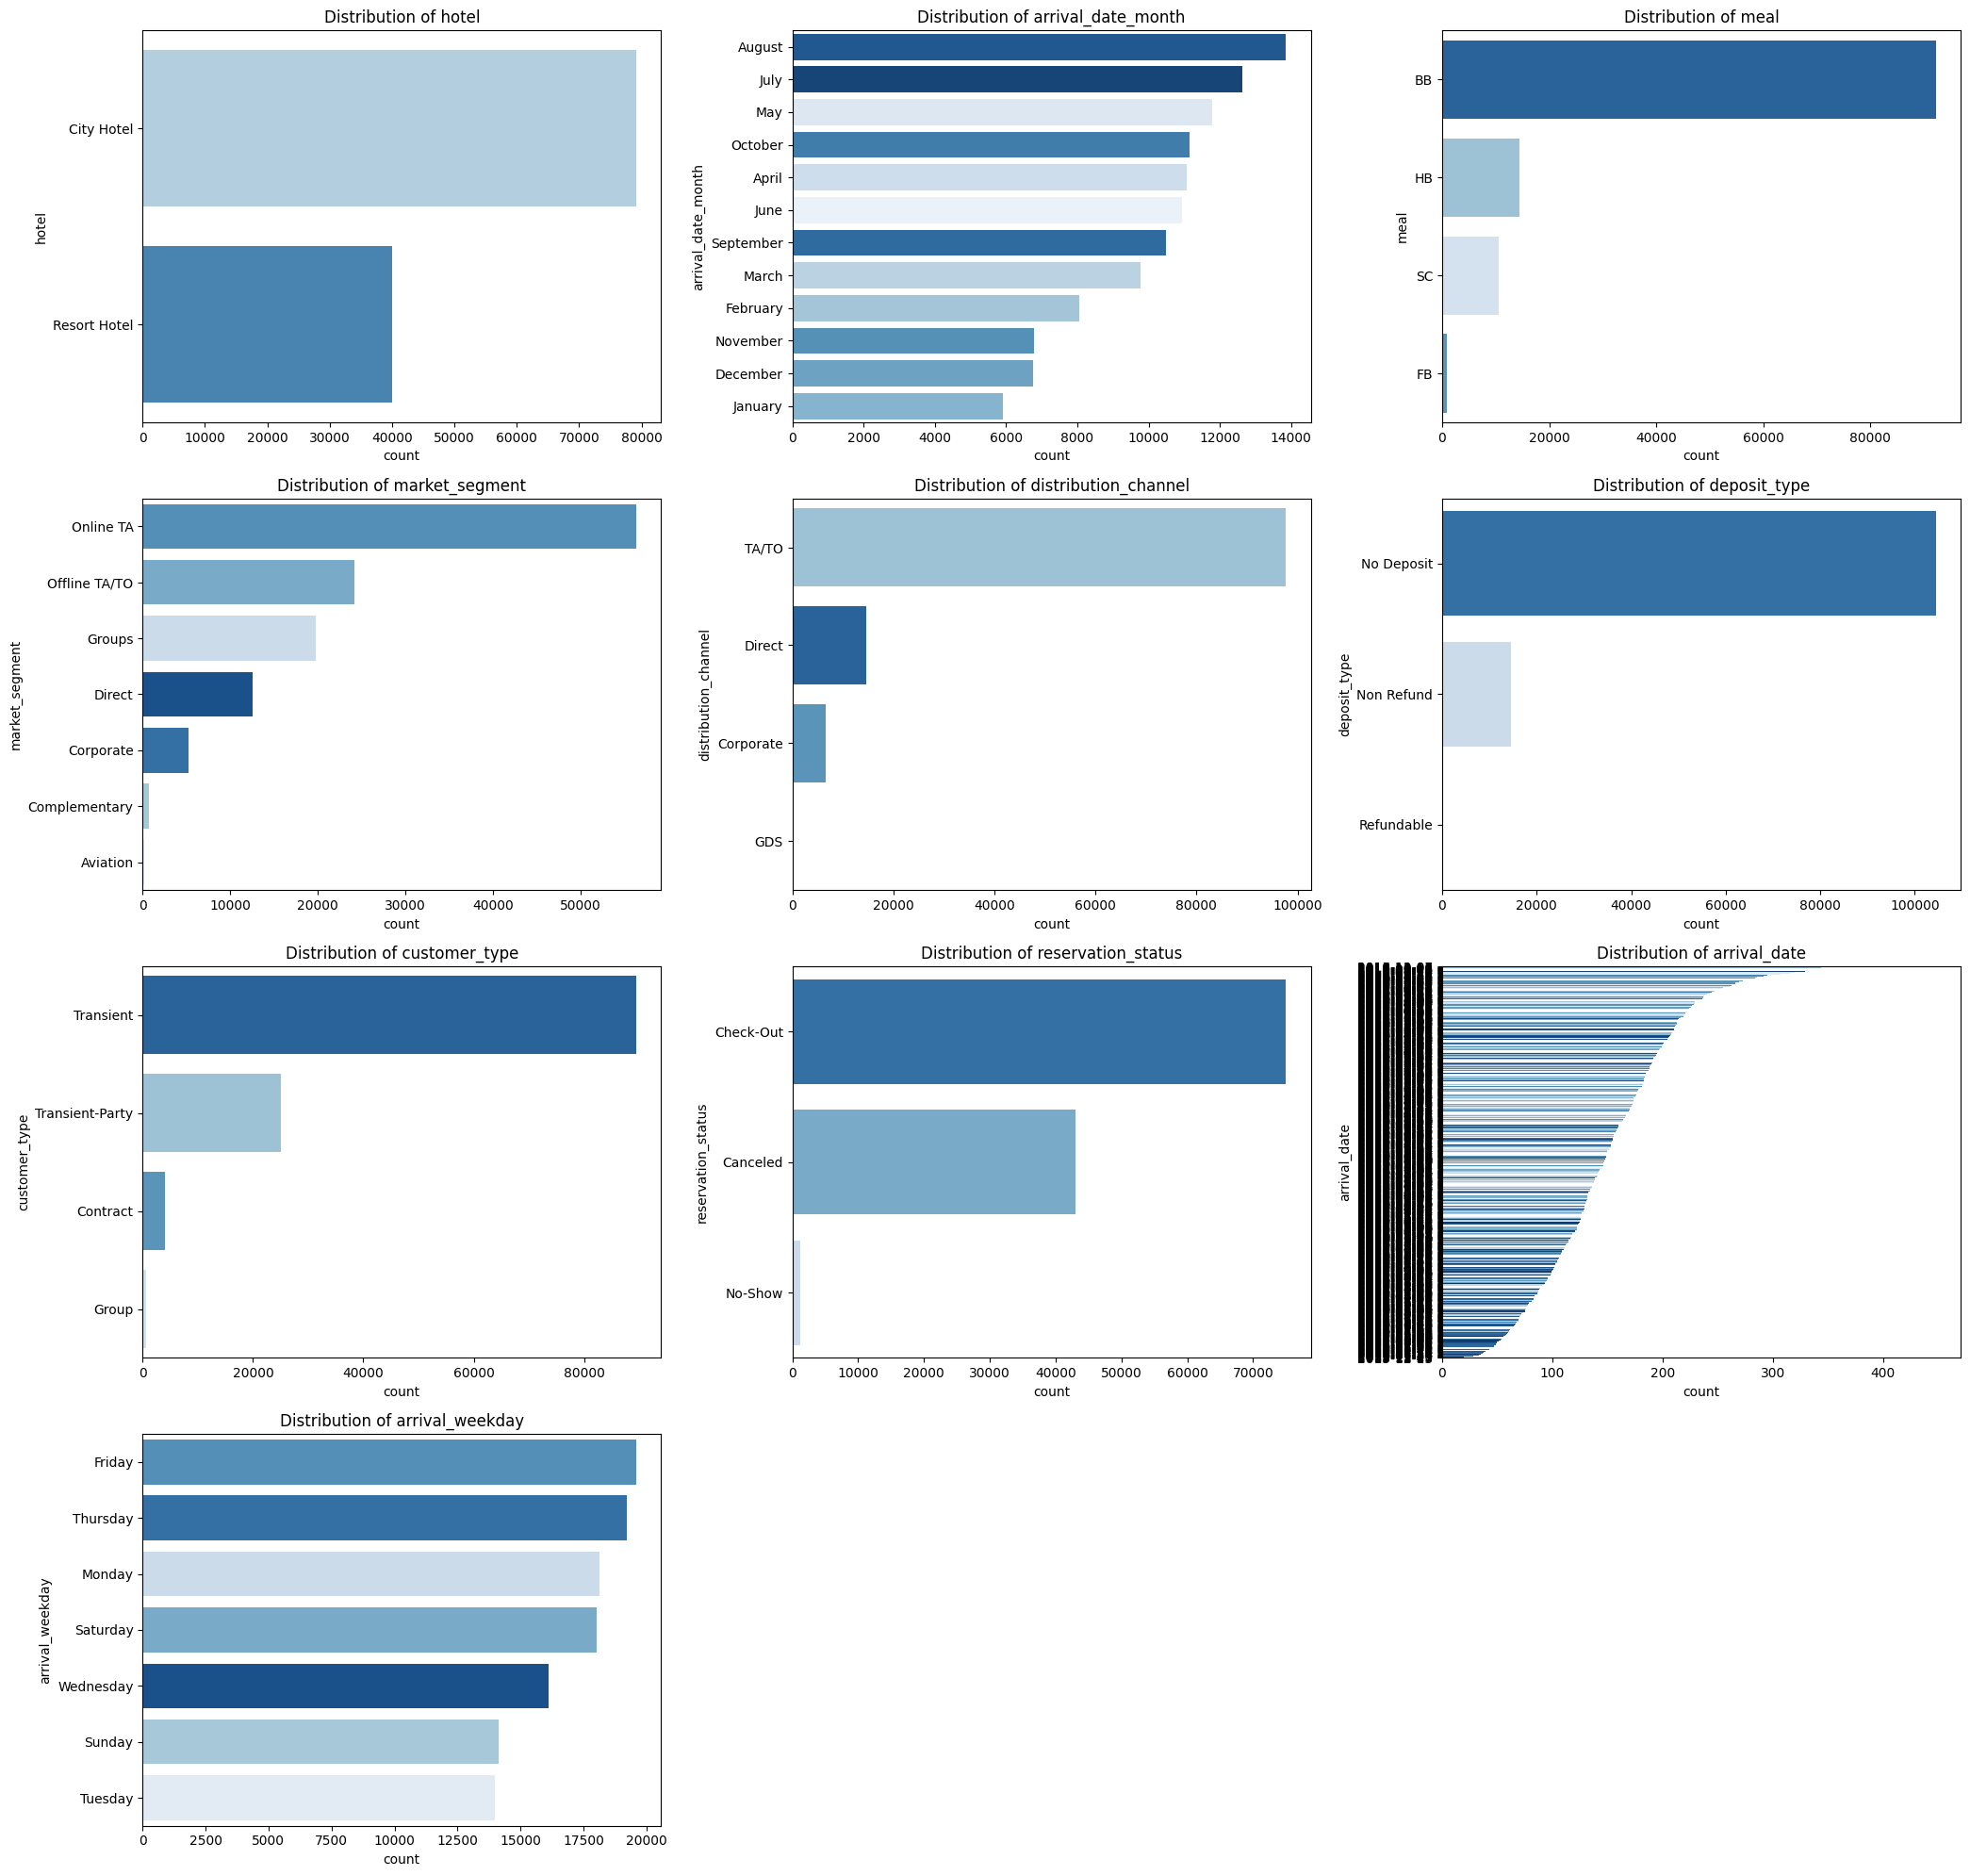

In [21]:
exclude_cols = ['reservation_status_date', 'country',"assigned_room_type","reserved_room_type"]
exclude_values = ['Undefined', 'None']

categorical_features = [
    col for col in df.select_dtypes(include=['object', 'category']).columns
    if col not in exclude_cols
]

# Subplot layout
n_cat = len(categorical_features)
n_cols = 3
n_rows = math.ceil(n_cat / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    filtered_df = df[~df[col].isin(exclude_values)]

    sns.countplot(
        y=filtered_df[col],
        hue=filtered_df[col],
        order=filtered_df[col].value_counts().index,
        ax=axes[i],
        palette="Blues_r",
        legend=False
    )
    axes[i].set_title(f"Distribution of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2.6) Correlation Analysis

In [22]:
corr_vars = ["lead_time", "adr", "total_guests", "total_nights", "is_canceled"]

corr_matrix = np.corrcoef(df[corr_vars].dropna().values.T)

corr_df = pd.DataFrame(
    corr_matrix,
    index=corr_vars,
    columns=corr_vars
)

corr_df

,lead_time,adr,total_guests,total_nights,is_canceled
lead_time,1.000000,-0.065018,0.070210,0.158294,0.292876
adr,-0.065018,1.000000,0.363711,0.069760,0.046492
total_guests,0.070210,0.363711,1.000000,0.118753,0.044826
total_nights,0.158294,0.069760,0.118753,1.000000,0.018554
is_canceled,0.292876,0.046492,0.044826,0.018554,1.000000


## 2.7) Seasonal Analysis by Hotel Type

In [23]:
seasonal_adr = df.groupby(["arrival_month", "hotel"])["adr"].mean()
seasonal_adr

arrival_month  hotel       
1              City Hotel       82.754477
               Resort Hotel     49.507033
2              City Hotel       85.327519
               Resort Hotel     55.189716
3              City Hotel       92.973339
               Resort Hotel     57.554652
4              City Hotel      111.397415
               Resort Hotel     77.849496
5              City Hotel      121.764614
               Resort Hotel     78.758134
6              City Hotel      119.186056
               Resort Hotel    110.481032
7              City Hotel      110.945950
               Resort Hotel    155.181299
8              City Hotel      114.857330
               Resort Hotel    186.790574
9              City Hotel      110.120296
               Resort Hotel     93.252030
10             City Hotel      100.119313
               Resort Hotel     62.132572
11             City Hotel       88.372486
               Resort Hotel     48.313643
12             City Hotel       89.209560
      

City Hotels display relatively stable pricing throughout the year, while Resort Hotels experience strong seasonal fluctuations with significantly higher ADRs during the summer months, reflecting leisure-driven demand.

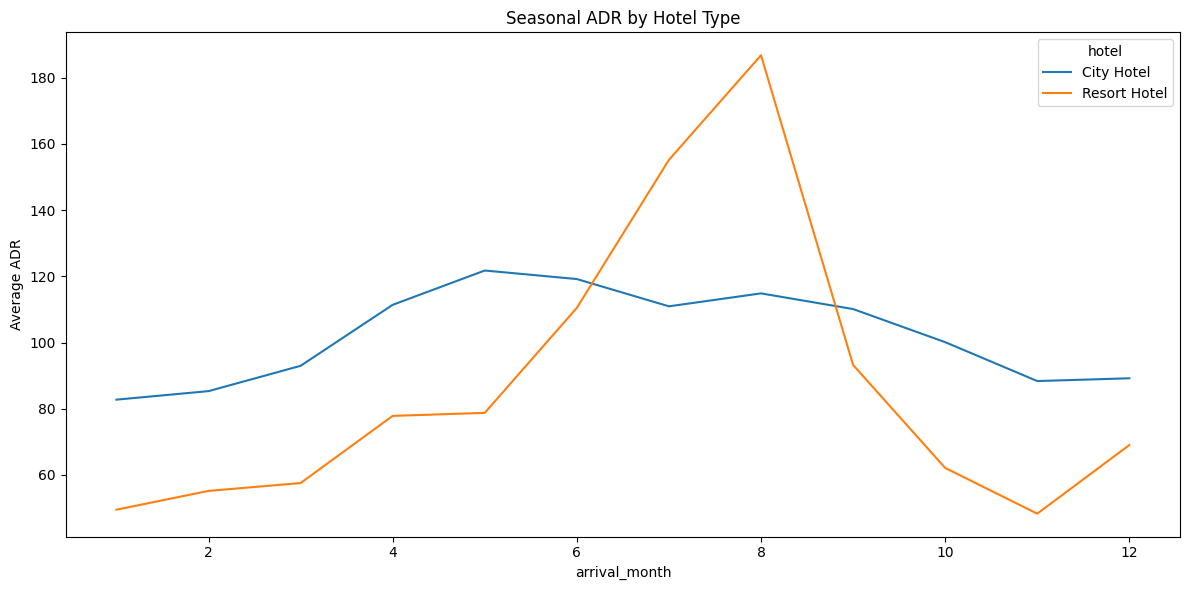

In [24]:
seasonal_adr.unstack().plot(figsize=(12, 6))
plt.ylabel("Average ADR")
plt.title("Seasonal ADR by Hotel Type")
plt.tight_layout()
plt.show()

# 3) Modeling

Predictive modeling to forecast hotel booking cancellations using three approaches: Linear Probability Model, Logistic Regression, and Random Forest.

## 3.1) Feature Engineering

In [25]:
# Create separate modeling dataframe
df_model = df.copy()

# Basic target variable
y = df_model["is_canceled"].astype(float)

# Simple, stable features (mostly numeric)
df_model["total_guests"] = (
    df_model.get("adults", 0).fillna(0)
    + df_model.get("children", 0).fillna(0)
    + df_model.get("babies", 0).fillna(0)
)

# Binary encode hotel type (City=1, Resort=0)
df_model["hotel_city"] = (df_model["hotel"] == "City Hotel").astype(int)
feature_cols = [
    "lead_time",
    "adr",
    "stays_in_week_nights",
    "stays_in_weekend_nights",
    "total_guests",
    "hotel_city",
    "previous_cancellations",
    "booking_changes"
]

X_df = df_model[feature_cols].copy()

# Quickly handle missing values
X_df = X_df.replace([np.inf, -np.inf], np.nan)
mask = X_df.notna().all(axis=1) & y.notna()

X = X_df.loc[mask].to_numpy(dtype=float)
y = y.loc[mask].to_numpy(dtype=float)

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

Feature matrix shape: (119210, 8)
Target variable shape: (119210,)


## 3.2) Train/Test Split and Standardization

In [26]:
# Reproducible shuffle
rng = np.random.default_rng(42)
n = X.shape[0]
idx = rng.permutation(n)

# Train/test split (80/20)
split = int(0.8 * n)
train_idx = idx[:split]
test_idx = idx[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Z-score standardization
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)
sigma[sigma == 0] = 1.0

X_train_s = (X_train - mu) / sigma
X_test_s = (X_test - mu) / sigma

# Intercept (design matrix)
X_train_design = np.column_stack([np.ones(X_train_s.shape[0]), X_train_s])
X_test_design = np.column_stack([np.ones(X_test_s.shape[0]), X_test_s])

print("Design shapes:", X_train_design.shape, X_test_design.shape)

Train shapes: (95368, 8) (95368,)
Test shapes: (23842, 8) (23842,)
Design shapes: (95368, 9) (23842, 9)


## 3.3) Linear Probability Model

In [27]:
# Fit model using least squares: minimize squared errors
beta, residuals, ran, s = np.linalg.lstsq(X_train_design, y_train, rcond=None)

# Predictions on train and test
y_pred_train = X_train_design @ beta
y_pred_test = X_test_design @ beta

# Quick sanity checks (first 5 predictions)
print("Beta shape:", beta.shape)
print("First 5 train predictions:", y_pred_train[:5])
print("First 5 test predictions:", y_pred_test[:5])

# Clip predictions to [0,1] for interpretability
y_pred_test_clipped = np.clip(y_pred_test, 0, 1)
print("Test predictions clipped range:", y_pred_test_clipped.min(), y_pred_test_clipped.max())

Beta shape: (9,)
First 5 train predictions: [0.35859901 0.08483993 0.37441866 0.30191773 0.30437075]
First 5 test predictions: [0.37637164 0.58999538 0.44977255 0.43697456 0.4338385 ]
Test predictions clipped range: 0.0 1.0


In [28]:
# Evaluation metrics
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

# Model performance
train_mse = mse(y_train, y_pred_train)
test_mse = mse(y_test, y_pred_test)

train_r2 = r2(y_train, y_pred_train)
test_r2 = r2(y_test, y_pred_test)

# Baseline model
baseline_pred_train = np.full_like(y_train, y_train.mean())
baseline_pred_test = np.full_like(y_test, y_train.mean())

baseline_train_mse = mse(y_train, baseline_pred_train)
baseline_test_mse = mse(y_test, baseline_pred_test)

lpm_metrics = {
    "Train MSE": [round(train_mse, 4)],
    "Test MSE": [round(test_mse, 4)],
    "Train R²": [round(train_r2, 4)],
    "Test R²": [round(test_r2, 4)],
    "Baseline Train MSE": [round(baseline_train_mse, 4)],
    "Baseline Test MSE": [round(baseline_test_mse, 4)],
}

pd.DataFrame(lpm_metrics, index=["Linear Probability Model"])

,Train MSE,Test MSE,Train R²,Test R²,Baseline Train MSE,Baseline Test MSE
Linear Probability Model,0.2031,0.2037,0.1292,0.1285,0.2332,0.2337


**Linear Probability Model Interpretation**

The linear probability model serves as a simple and interpretable baseline for analyzing cancellation behavior. It outperforms a naive mean-based baseline, indicating that booking characteristics contain useful predictive information, although overall predictive performance remains limited due to the binary nature of the target. Consequently, the model is primarily valuable for understanding the direction and relative importance of key features rather than for accurate individual-level prediction.

## 3.4) Logistic Regression for Cancellation Prediction

To complement the linear probability model, we fit a logistic regression model to predict booking cancellations. Logistic regression is more appropriate for binary outcomes, as it directly models probabilities in the [0,1] interval and often provides improved predictive performance. The goal of this section is to assess whether a more flexible model can outperform the linear model in terms of prediction accuracy.

In [29]:
# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_s, y_train)

# Predictions
y_pred_test_lr = logreg.predict(X_test_s)
y_prob_test_lr = logreg.predict_proba(X_test_s)[:, 1]

# Evaluation metrics
acc = accuracy_score(y_test, y_pred_test_lr)
auc = roc_auc_score(y_test, y_pred_test_lr)

logreg_metrics = {
    "Test Accuracy": [round(acc, 4)],
    "Test AUC": [round(auc, 4)],
    "Recall (Canceled=1)": [round(
        recall_score(y_test, y_pred_test_lr, pos_label=1)
    , 4)]
}

pd.DataFrame(logreg_metrics, index=["Logistic Regression"])

,Test Accuracy,Test AUC,Recall (Canceled=1)
Logistic Regression,0.6966,0.6277,0.3572


**Logistic Regression Results Interpretation**

The logistic regression model achieves a test accuracy of 0.70 and an AUC of 0.632, indicating moderate predictive performance. The model correctly identifies most non-canceled bookings, but has lower recall for canceled bookings, reflecting the inherent difficulty of predicting cancellations. Overall, logistic regression provides improved and more realistic predictions compared to the linear probability model.

## 3.5) Random Forest Classifier

In [30]:
# Fit Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)

# Predictions
y_pred_test_rf = rf.predict(X_test_s)
y_prob_test_rf = rf.predict_proba(X_test_s)[:, 1]

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_test_rf)
auc_rf = roc_auc_score(y_test, y_pred_test_rf)
recall_rf_1 = recall_score(y_test, y_pred_test_rf, pos_label=1)

rf_metrics = pd.DataFrame({
    "Test Accuracy": [round(acc_rf, 4)],
    "Test AUC": [round(auc_rf, 4)],
    "Recall (Canceled=1)": [round(recall_rf_1, 4)]
}, index=["Random Forest (tuned)"])

rf_metrics

,Test Accuracy,Test AUC,Recall (Canceled=1)
Random Forest (tuned),0.7691,0.7108,0.4818


In [31]:
# Classification report
report_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)
report_rf_df = pd.DataFrame(report_rf).T.round(4)

report_rf_df

,precision,recall,f1-score,support
0.0,0.7534,0.9397,0.8363,14961.0000
1.0,0.8259,0.4818,0.6086,8881.0000
accuracy,0.7691,0.7691,0.7691,0.7691
macro avg,0.7896,0.7108,0.7224,23842.0000
weighted avg,0.7804,0.7691,0.7515,23842.0000


In [32]:
rf_importances = (
    pd.Series(rf.feature_importances_, index=feature_cols)
      .sort_values(ascending=False)
      .round(4)
      .to_frame(name="Importance")
)

rf_importances

,Importance
lead_time,0.3885
adr,0.1867
previous_cancellations,0.1849
booking_changes,0.0975
stays_in_week_nights,0.0486
hotel_city,0.0335
total_guests,0.0331
stays_in_weekend_nights,0.0273


The random forest model achieves the strongest predictive performance and improves recall for canceled bookings. Feature importance analysis consistently identifies lead time, previous cancellations, and ADR as the most important drivers of cancellations.

In [33]:
# Tuning of max depth parameter
results = []

for depth in [8, 10, 12, 15]:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_s, y_train)
    y_prob = rf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results.append((depth, auc))

print("Hyperparameter tuning results (max_depth vs AUC):")
for depth, auc in results:
    print(f"  max_depth={depth}: AUC={auc:.4f}")

Hyperparameter tuning results (max_depth vs AUC):
  max_depth=8: AUC=0.7833
  max_depth=10: AUC=0.7979
  max_depth=12: AUC=0.8114
  max_depth=15: AUC=0.8281


A limited hyperparameter search over the maximum tree depth shows a consistent improvement in AUC as model complexity increases. The random forest with max_depth = 15 achieves the best performance, indicating that non-linear effects and feature interactions play an important role in cancellation prediction. No clear signs of overfitting are observed within the tested range.

## 3.6) Model Comparison

In [34]:
comparison = pd.DataFrame({
    "Model": [
        "Linear Probability Model (NumPy)",
        "Logistic Regression",
        "Random Forest (tuned)"
    ],
    "Metrics": [
        "Test MSE = 0.2037, Test R² = 0.1285",
        "Test Accuracy = 0.6966, Test AUC = 0.6277",
        "Test Accuracy = 0.7691, Test AUC = 0.7108"
    ],
    "Best For": [
        "Interpretability (direction of effects)",
        "Simple prediction + probability estimates",
        "Best predictive performance"
    ],
    "Key Notes": [
        "Outperforms baseline MSE (mean predictor)",
        "Struggles to recall cancellations (class 1)",
        "Improves recall for cancellations + captures non-linearity"
    ]
})

comparison

,Model,Metrics,Best For,Key Notes
0,Linear Probability Model (NumPy),"Test MSE = 0.2037, Test R² = 0.1285",Interpretability (direction of effects),Outperforms baseline MSE (mean predictor)
1,Logistic Regression,"Test Accuracy = 0.6966, Test AUC = 0.6277",Simple prediction + probability estimates,Struggles to recall cancellations (class 1)
2,Random Forest (tuned),"Test Accuracy = 0.7691, Test AUC = 0.7108",Best predictive performance,Improves recall for cancellations + captures n...


## 3.7) Visual Model Diagnostics

### 3.7.1) ROC Curve

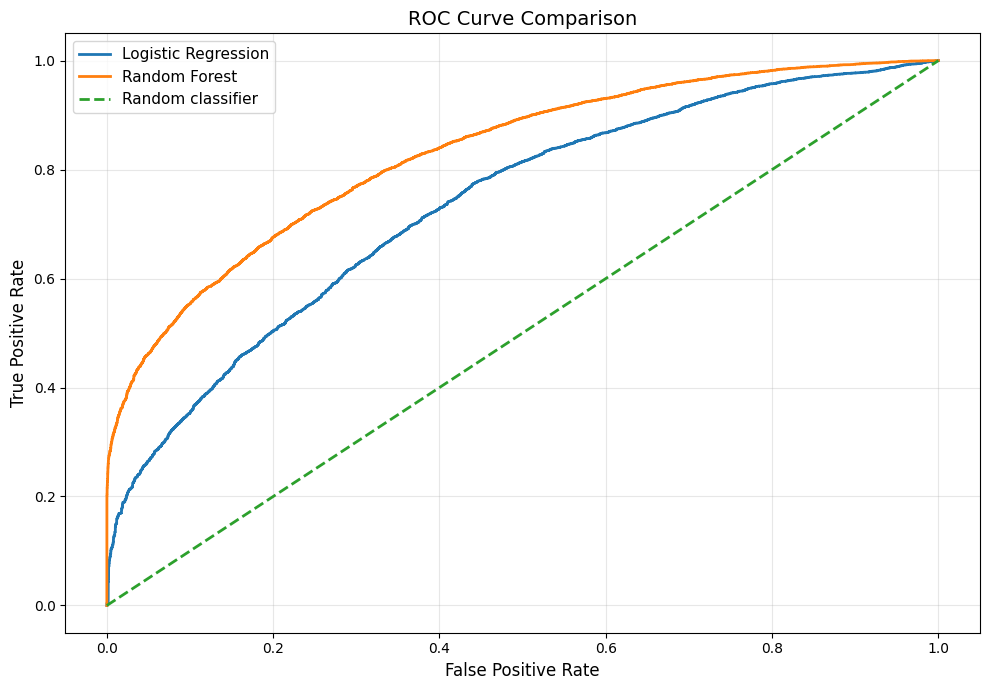

In [35]:
# ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_test_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_test_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label="Random Forest", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier", linewidth=2)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The ROC curves show that the random forest consistently outperforms logistic regression across classification thresholds, resulting in a higher AUC and better discrimination between canceled and non-canceled bookings.

### 3.7.2) Confusion Matrix

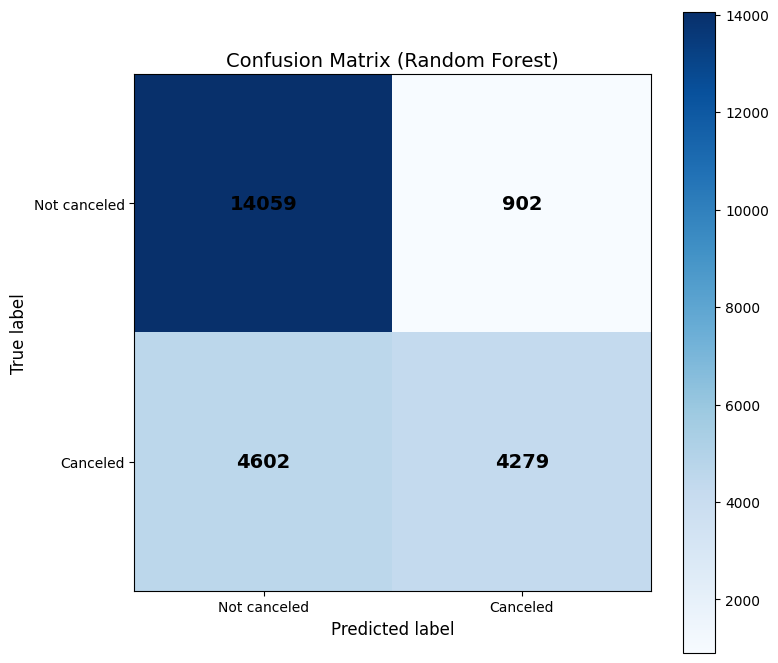

In [36]:
cm = confusion_matrix(y_test, y_pred_test_rf)

plt.figure(figsize=(8, 7))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Random Forest)", fontsize=14)
plt.colorbar()
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)

ticks = np.arange(2)
plt.xticks(ticks, ["Not canceled", "Canceled"])
plt.yticks(ticks, ["Not canceled", "Canceled"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

The confusion matrix shows that the random forest model correctly identifies most non-canceled bookings, resulting in high overall accuracy. Approximately 48% of canceled bookings are correctly detected, while a substantial number of cancellations remain misclassified as non-canceled. This reflects a conservative prediction strategy that prioritizes avoiding false alarms over capturing all cancellations, highlighting a trade-off between recall and precision in cancellation prediction.

## 3.8) Business Insights & Recommendations

**Lead Time as the Strongest Predictor**

Lead time is the strongest predictor of cancellations. Bookings made far in advance show a significantly higher cancellation risk, suggesting that hotels could apply stricter cancellation policies or targeted reminders for long lead-time reservations.

**Past Cancellation Behavior**

Past cancellation behavior is highly informative. Guests with previous cancellations are more likely to cancel again, indicating potential value in customer-level risk scoring or differentiated booking conditions.

**Non-Linear Effects**

Non-linear effects play an important role. The random forest model substantially outperforms linear and logistic models, highlighting complex interactions between booking characteristics that simpler models fail to capture.

**Recall-Precision Trade-off**

Cancellation prediction involves a trade-off between recall and false alarms. While the model achieves good overall accuracy, a notable share of cancellations remains undetected, suggesting that threshold tuning or cost-sensitive strategies may be needed depending on business priorities.

**Operational Applications**

Predictive models can support operational decision-making. Accurate cancellation risk estimates can inform overbooking strategies, targeted incentives, and capacity planning, ultimately reducing revenue loss from last-minute cancellations.